In [ ]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler
import json
import pickle
import random
import time
import os
import requests
from collections import Counter
import unittest
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# NLTK Resources Download

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Loading Dataset

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Financial_Sentiment_Analysis/data.csv"
df = pd.read_csv(data_path)

Mounted at /content/drive


In [ ]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3130
positive,1852
negative,860


In [ ]:
df.isna().sum()

,0
Sentence,0
Sentiment,0


In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(5836, 2)

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3124
positive,1852
negative,860


# Plotting Sentiment Distribution

In [ ]:
# Plotting the distribution of sentiment
def plot_sentiment_distribution(df):
    sentiment_counts = df['Sentiment'].value_counts()

    ax = sentiment_counts.plot(kind='bar')
    plt.title('Distribution of Sentiment', fontsize=10)
    plt.xlabel('Sentiment', fontsize=8)
    plt.ylabel('Count', fontsize=8)
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8)

    for i, count in enumerate(sentiment_counts):
        ax.text(i, count + 0.1, str(count), ha='center', fontsize=8)

    plt.show()

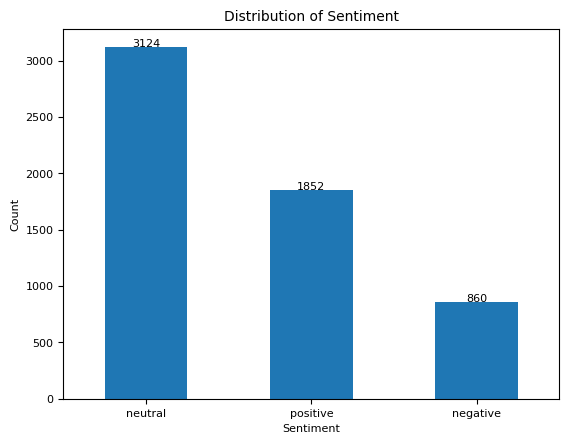

In [ ]:
plot_sentiment_distribution(df)

# Balancing Dataset

In [ ]:
# Separate the data by class
neutral_df = df[df['Sentiment'] == 'neutral']
positive_df = df[df['Sentiment'] == 'positive']
negative_df = df[df['Sentiment'] == 'negative']

# 1. Downsample the 'neutral' class (reduce to 1852 examples)
neutral_df_downsampled = resample(neutral_df,
                                  replace=False,
                                  n_samples=1852,
                                  random_state=42)

# 2. Upsample the 'negative' class (increase to 1852 examples)
negative_df_upsampled = resample(negative_df,
                                 replace=True,
                                 n_samples=1852,
                                 random_state=42)

# 3. Combine all the balanced data into a new dataframe
df = pd.concat([neutral_df_downsampled, positive_df, negative_df_upsampled])

# Verify that the dataframe is now balanced
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,1852
positive,1852
negative,1852


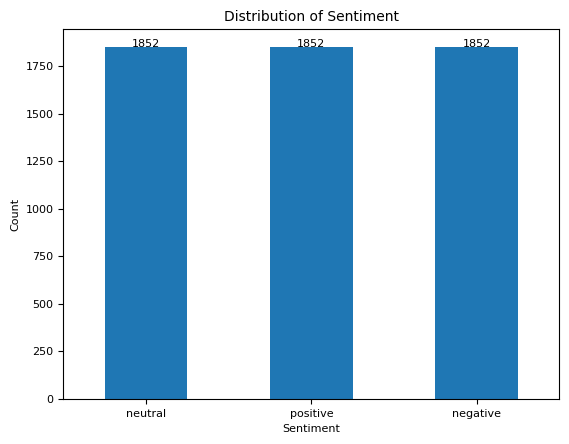

In [ ]:
# Plot the distribution of sentiment
plot_sentiment_distribution(df)

# Generating Word Cloud

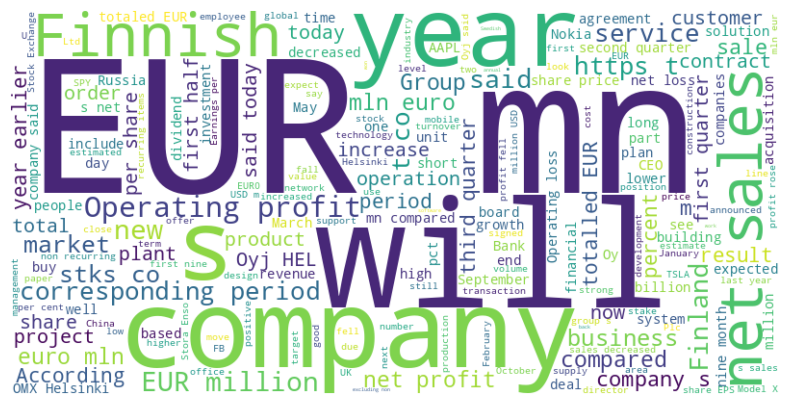

In [ ]:
# Combine all the sentences from the 'Sentence' column into one string
text = ' '.join(df['Sentence'])

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axes
plt.show()


# Generating Word Frequency Plot

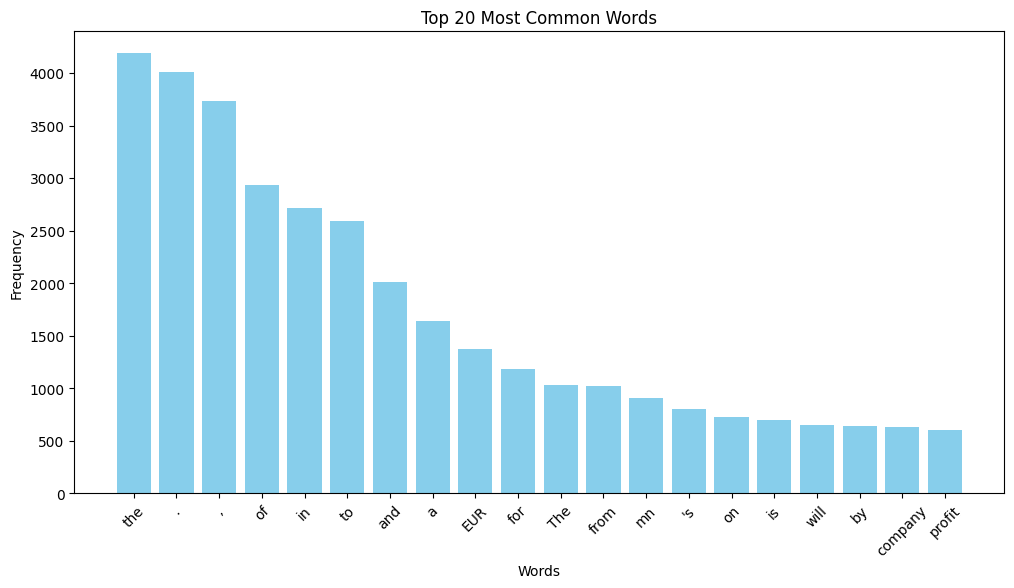

In [ ]:
# Combine all the sentences from the correct column
text = ' '.join(df['Sentence'])

# Tokenize the text (split into words)
words = text.split()

# Count the frequency of each word
word_freq = Counter(words)

# Create a DataFrame from the word frequency dictionary
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Select the top 20 most common words
top_words = word_freq_df.head(20)

# Generate the bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_words['Word'], top_words['Frequency'], color='skyblue')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Text Preprocessing Functions

In [ ]:
def count_tokens(text):
    """Counts the number of tokens in a string or pandas Series."""
    if isinstance(text, pd.Series):
        total_count = text.apply(lambda x: len([token for token in word_tokenize(str(x)) if token.isalnum()])).sum()
    else:
        total_count = len([token for token in word_tokenize(str(text)) if token.isalnum()])
    return total_count

def expand_contractions(text):
    """Expands common contractions in English."""
    contractions = {
        "can't": "cannot",
        "don't": "do not",
        "won't": "will not",
        "I'm": "I am",
        "he's": "he is",
        "she's": "she is",
        "it's": "it is",
        "they're": "they are",
        "you're": "you are",
        "we're": "we are",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
    }

    for contraction, expanded in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expanded, text)

    return text

def lemmatize_tokens(tokens):
    """Lemmatizes the tokens (implement as needed)."""
    # Placeholder for lemmatization logic (not implemented here)
    return tokens

def remove_emojis(text):
    """Removes emojis from a string."""
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F]")
    return emoji_pattern.sub('', text)

def remove_html_tags(text):
    """Removes HTML tags from a string."""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_negation(text):
    """Removes negation words and replaces them with their positive form."""
    negation_patterns = {
        "don't": "do",
        "doesn't": "does",
        "won't": "will",
        "can't": "can",
        "isn't": "is",
        "aren't": "are",
        "wasn't": "was",
        "weren't": "were",
        "no": "yes",
        "not": ""
    }

    for negation, replacement in negation_patterns.items():
        text = re.sub(r'\b' + re.escape(negation) + r'\b', replacement, text, flags=re.IGNORECASE)

    return text.strip()

def remove_punctuation(text):
    """Removes punctuation from a string."""
    return re.sub(r'[^\w\s]', '', text)

def remove_special_characters(text):
    """Removes special characters from a string."""
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_stopwords(tokens):
    """Removes stopwords from a list of tokens."""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token.lower() not in stop_words]

def remove_urls(text):
    """Removes URLs from a string."""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def stem_tokens(tokens):
    """Stems the tokens."""
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def to_lower(text):
    """Converts a string to lowercase."""
    return text.lower()

def tokenize_text(text):
    """Tokenizes a string into words."""
    return word_tokenize(text)

# Text Processing Unit Tests

In [ ]:
class TestTextProcessing(unittest.TestCase):

    def test_count_tokens_string(self):
        original_text = "This is a test."
        total_tokens = count_tokens(original_text)
        self.assertEqual(total_tokens, 4)

    def test_count_tokens_series_of_strings(self):
        original_text = pd.Series(["This is the first test.", "This is the second test."])
        total_tokens = count_tokens(original_text)
        self.assertEqual(total_tokens, 10)

    def test_expand_contractions(self):
        original_text = "I'm not going to the party."
        transformed_text = expand_contractions(original_text)
        self.assertEqual(transformed_text, "I am not going to the party.")

    def test_lemmatize_tokens(self):
        tokens = ["running", "ran", "swimming", "swam"]
        transformed_tokens = lemmatize_tokens(tokens)
        self.assertEqual(transformed_tokens, tokens)

    def test_remove_emojis(self):
        original_text = "Investing is exciting 😊 money_bag"
        transformed_text = remove_emojis(original_text)
        self.assertEqual(transformed_text, "Investing is exciting  money_bag")

    def test_remove_html_tags(self):
        original_text = "<p>This is a <strong>test</strong>.</p>"
        transformed_text = remove_html_tags(original_text)
        self.assertEqual(transformed_text, "This is a test.")

    def test_remove_negation(self):
        original_text = "I don't think this investment is bad."
        transformed_text = remove_negation(original_text)
        self.assertEqual(transformed_text, "I do think this investment is bad.")

    def test_remove_punctuation(self):
        original_text = "Hello, world!"
        transformed_text = remove_punctuation(original_text)
        self.assertEqual(transformed_text, "Hello world")

    def test_remove_special_characters(self):
        original_text = "Special @characters# should be $removed!"
        transformed_text = remove_special_characters(original_text)
        self.assertEqual(transformed_text, "Special characters should be removed")

    def test_remove_stopwords(self):
        tokens = ["This", "is", "a", "test"]
        transformed_tokens = remove_stopwords(tokens)
        self.assertEqual(transformed_tokens, ["test"])

    def test_remove_urls(self):
        original_text = "Visit us at https://www.example.com"
        transformed_text = remove_urls(original_text)
        self.assertEqual(transformed_text, "Visit us at ")

    def test_stem_tokens(self):
        tokens = ["investing", "investment", "invest"]
        transformed_tokens = stem_tokens(tokens)
        self.assertEqual(transformed_tokens, ["invest", "invest", "invest"])

    def test_to_lower(self):
        original_text = "HELLO World"
        transformed_text = to_lower(original_text)
        self.assertEqual(transformed_text, "hello world")

    def test_tokenize_text(self):
        original_text = "The revenue growth rate is impressive."
        transformed_text = tokenize_text(original_text)
        self.assertEqual(transformed_text, ["The", "revenue", "growth", "rate", "is", "impressive", "."])


# Run the test:
if __name__ == '__main__':
    unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestTextProcessing))

..............
----------------------------------------------------------------------
Ran 14 tests in 0.102s

OK


# Text Preprocessing Pipeline

In [ ]:
# Total tokens before preprocessing
print(f"Total tokens before preprocessing: {count_tokens(df['Sentence'])}")

# Create a DataFrame to store the token count after each operation
token_count_df = pd.DataFrame(columns=["Operation", "Token Count After"])

# Define the text processing operations
operations = [
    remove_html_tags,
    remove_urls,
    remove_emojis,
    expand_contractions,
    remove_negation,
    remove_special_characters,
    remove_punctuation,
    to_lower,
    tokenize_text,
    remove_stopwords,
    lemmatize_tokens,
    stem_tokens,
]

# Apply the text processing operations
for operation in operations:
    print(f"Applying operation: {operation.__name__}")
    df["Sentence"] = df["Sentence"].apply(operation)

    # Count tokens after each operation
    token_count = count_tokens(df['Sentence'])

    # Store the results in the DataFrame
    token_count_df = pd.concat(
        [token_count_df, pd.DataFrame({"Operation": [operation.__name__], "Token Count After": [token_count]})],
        ignore_index=True
    )

# Total tokens after preprocessing
print(f"Total tokens after preprocessing: {count_tokens(df['Sentence'])}")

# Display the token count DataFrame
token_count_df

Total tokens before preprocessing: 95994
Applying operation: remove_html_tags
Applying operation: remove_urls
Applying operation: remove_emojis
Applying operation: expand_contractions
Applying operation: remove_negation
Applying operation: remove_special_characters
Applying operation: remove_punctuation
Applying operation: to_lower
Applying operation: tokenize_text
Applying operation: remove_stopwords
Applying operation: lemmatize_tokens
Applying operation: stem_tokens
Total tokens after preprocessing: 804


,Operation,Token Count After
0,remove_html_tags,95991
1,remove_urls,95623
2,remove_emojis,95623
3,expand_contractions,95658
4,remove_negation,95543
5,remove_special_characters,101353
6,remove_punctuation,101353
7,to_lower,101353
8,tokenize_text,2624
9,remove_stopwords,804


# Concatenating Tokens into Text

In [ ]:
# Concatenate all tokens into a single string
all_tokens = ' '.join(df['Sentence'].astype(str))

# Generating Word Cloud, Word Frequency Plot, and Top 10 Most Frequent Terms

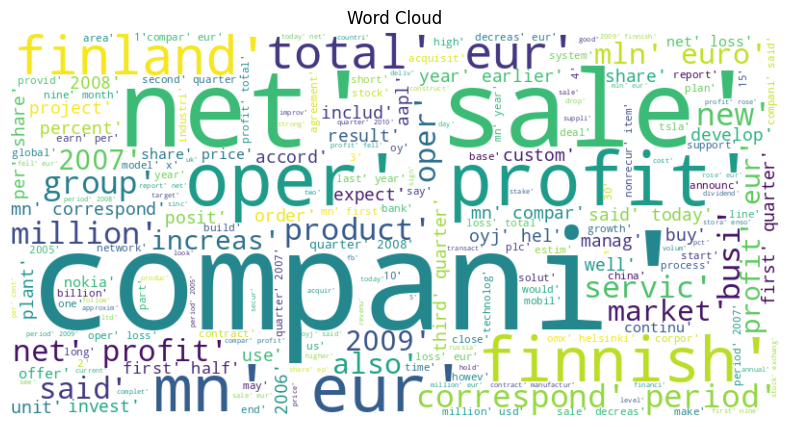

In [ ]:
all_text = ' '.join(all_tokens)
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

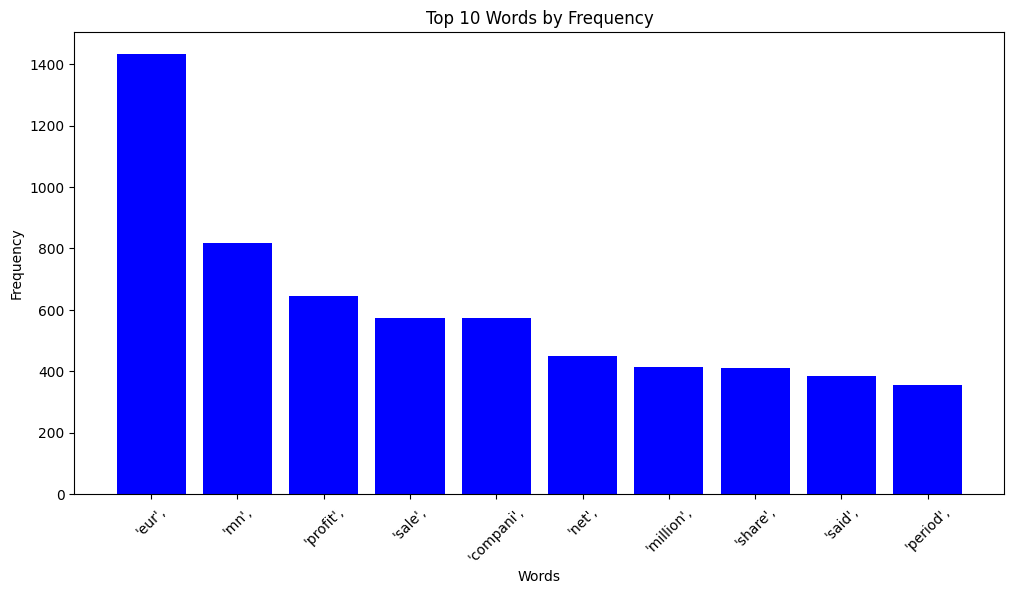

In [ ]:
# Calculate word frequency
word_frequency = Counter(all_tokens.split())

# Create a DataFrame for plotting
freq_df = pd.DataFrame(word_frequency.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the word frequency
plt.figure(figsize=(12, 6))
plt.bar(freq_df['Word'][:10], freq_df['Frequency'][:10], color='blue')
plt.title('Top 10 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate word frequency
word_frequency = Counter(all_tokens.split())

# Get the top 10 most frequent terms
top_10_terms = word_frequency.most_common(10)

# Create a DataFrame for the top 10 terms
top_10_df = pd.DataFrame(top_10_terms, columns=['Term', 'Frequency'])

# Display the top 10 terms DataFrame
top_10_df

,Term,Frequency
0,"'eur',",1433
1,"'mn',",819
2,"'profit',",646
3,"'sale',",574
4,"'compani',",572
5,"'net',",450
6,"'million',",413
7,"'share',",410
8,"'said',",384
9,"'period',",356


# Feature Engineering with TF-IDF Vectorization

In [ ]:
labels = df['Sentiment']

all_sentences = df['Sentence'].astype(str).tolist()

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
bow = vectorizer.fit_transform(all_sentences)

vectorizer2 = TfidfVectorizer(ngram_range=(1, 2), min_df=10)
bow2 = vectorizer2.fit_transform(all_sentences)

# Use Chi-Squared test to select the best features
selected_features = SelectKBest(chi2, k=5000).fit(bow2, labels).get_support(indices=True)
bestfeatures = [vectorizer2.get_feature_names_out()[t] for t in selected_features]

# Create a TF-IDF vectorizer with the top 5000 features
vectorizer3 = TfidfVectorizer(ngram_range=(1, 2), min_df=10, vocabulary=bestfeatures)
# Create the bag of words with selected features
bow3 = vectorizer3.fit_transform(all_sentences)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=1519. All the features will be returned.
  warnings.warn(


# Train-Test Split for Model Training

In [ ]:
# Split the data into training and testing sets
# Assume that 'labels' contains your labels (Sentiment) and 'bow3' contains the input data
X_train, X_test, y_train, y_test = train_test_split(bow3, labels, test_size=0.2, stratify=labels, random_state=42)

# Model Evaluation and Confusion Matrix Plotting

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Naive Bayes', 'mean_accuracy': 0.680167423217142, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.010036147326845508, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.5202483801295896, 'confusion_matrix': array([[1332,  293,  227],
       [ 337, 1276,  239],
       [ 265,  416, 1171]]), 'elapsed_time': 0.34581708908081055}


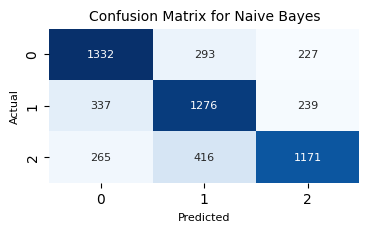

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Decision Tree', 'mean_accuracy': 0.692043916621878, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.005451710016516078, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.5380669546436285, 'confusion_matrix': array([[1614,  167,   71],
       [ 451, 1038,  363],
       [ 246,  413, 1193]]), 'elapsed_time': 7.06857442855835}


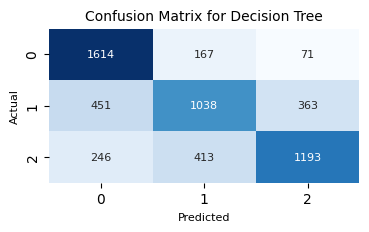

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Support Vector Machine', 'mean_accuracy': 0.7417219239909603, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.005774786951669186, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.6125809935205184, 'confusion_matrix': array([[1523,  250,   79],
       [ 339, 1265,  248],
       [ 135,  384, 1333]]), 'elapsed_time': 34.57287263870239}


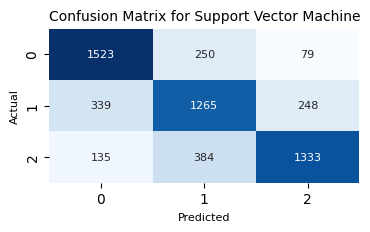

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Random Forest', 'mean_accuracy': 0.7309223008631799, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.009330820983913805, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.5901727861771058, 'confusion_matrix': array([[1530,  249,   73],
       [ 358, 1268,  226],
       [ 173,  439, 1240]]), 'elapsed_time': 72.2351667881012}


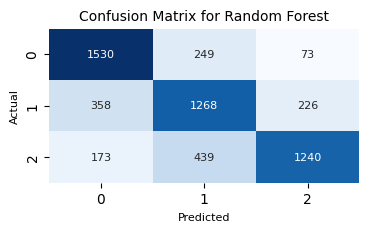

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Logistic Regression', 'mean_accuracy': 0.7190427316112906, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.008706687867514615, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.5785637149028078, 'confusion_matrix': array([[1488,  230,  134],
       [ 362, 1212,  278],
       [ 213,  344, 1295]]), 'elapsed_time': 1.1952118873596191}


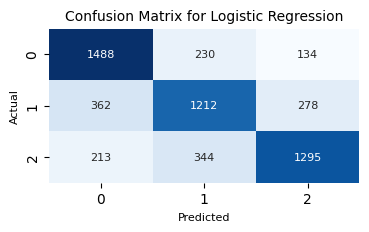

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Gradient Boosting', 'mean_accuracy': 0.6695474943177772, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.01114307355341235, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.505669546436285, 'confusion_matrix': array([[1319,  430,  103],
       [ 331, 1366,  155],
       [ 198,  614, 1040]]), 'elapsed_time': 60.026917457580566}


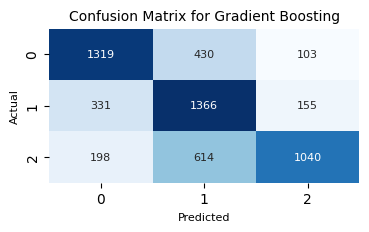

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'k-Nearest Neighbors', 'mean_accuracy': 0.4827231284279507, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.008682186750425739, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.22408207343412523, 'confusion_matrix': array([[1497,  277,   78],
       [ 880,  878,   94],
       [ 822,  723,  307]]), 'elapsed_time': 1.697929859161377}


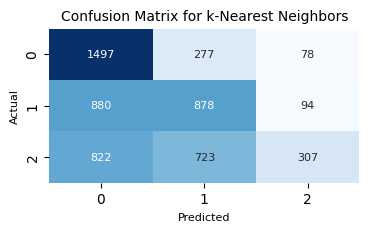

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Extra Trees', 'mean_accuracy': 0.7543209177032812, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.010589037131763243, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.6330993520518359, 'confusion_matrix': array([[1608,  167,   77],
       [ 350, 1247,  255],
       [ 111,  399, 1342]]), 'elapsed_time': 99.705561876297}


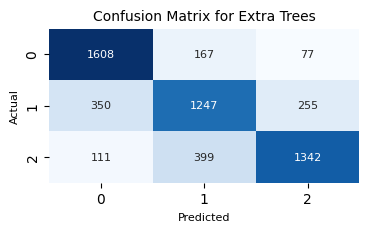

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10545
[LightGBM] [Info] Number of data points in the train set: 4444, number of used features: 579
[LightGBM] [Info] Start training from score -1.098837
[LightGBM] [Info] Start training from score -1.098837
[LightGBM] [Info] Start training from score -1.098162


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10582
[LightGBM] [Info] Number of data points in the train set: 4445, number of used features: 580
[LightGBM] [Info] Start training from score -1.098387
[LightGBM] [Info] Start training from score -1.099062
[LightGBM] [Info] Start training from score -1.098387


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10520
[LightGBM] [Info] Number of data points in the train set: 4445, number of used features: 573
[LightGBM] [Info] Start training from score -1.098387
[LightGBM] [Info] Start training from score -1.098387
[LightGBM] [Info] Start training from score -1.099062


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10492
[LightGBM] [Info] Number of data points in the train set: 4445, number of used features: 576
[LightGBM] [Info] Start training from score -1.098387
[LightGBM] [Info] Start training from score -1.098387
[LightGBM] [Info] Start training from score -1.099062


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10565
[LightGBM] [Info] Number of data points in the train set: 4445, number of used features: 590
[LightGBM] [Info] Start training from score -1.099062
[LightGBM] [Info] Start training from score -1.098387
[LightGBM] [Info] Start training from score -1.098387


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10545
[LightGBM] [Info] Number of data points in the train set: 4444, number of used features: 579
[LightGBM] [Info] Start training from score -1.098837
[LightGBM] [Info] Start training from score -1.098837
[LightGBM] [Info] Start training from score -1.098162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10582
[LightGBM] [Info] Number of data points in the train set: 4445, number of used features: 580
[LightGBM] [Info] Start training from score -1.098387
[LightGBM] [Info] Start training from score -1.099062
[LightGBM] [Info] Star

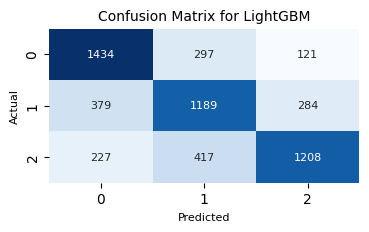

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2204, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/l

{'classifier': 'Stacking', 'mean_accuracy': 0.7831171606369269, 'mean_precision': nan, 'mean_recall': nan, 'mean_f1_score': nan, 'std_accuracy': 0.0069542531486794425, 'std_precision': nan, 'std_recall': nan, 'std_f1_score': nan, 'cohen_kappa': 0.6698164146868251, 'confusion_matrix': array([[1658,   87,  107],
       [ 327, 1210,  315],
       [  31,  356, 1465]]), 'elapsed_time': 647.4652051925659}


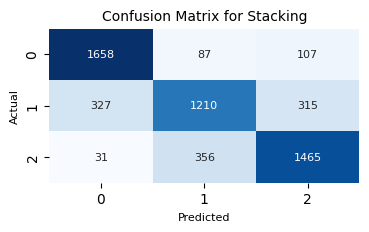

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                cbar=False, annot_kws={"size": 8})
    plt.title(f'Confusion Matrix for {classifier_name}', fontsize=10)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8)
    plt.show()

# Create a dictionary of classifiers
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "LightGBM": LGBMClassifier(),
    "Stacking": StackingClassifier(estimators=[('svm', SVC()),
                                               ('Extra Trees', ExtraTreesClassifier()),
                                               ],
                                               final_estimator=GradientBoostingClassifier())
}

results = []

# Train and evaluate the classifiers
for classifier_name, classifier in classifiers.items():
    start_time = time.time()

    # Define the scoring metrics
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, pos_label='positive'),
               'recall': make_scorer(recall_score, pos_label='positive'),
               'f1_score': make_scorer(f1_score, pos_label='positive')}

    # Perform cross-validation
    cross_validation_results = cross_validate(classifier, bow3, labels, cv=5, scoring=scoring)
    # Perform cross-validation predictions
    predicted = cross_val_predict(classifier, bow3, labels, cv=5)

    # Calculate the mean and standard deviation of the metrics
    mean_accuracy = np.mean(cross_validation_results['test_accuracy'])
    mean_precision = np.mean(cross_validation_results['test_precision'])
    mean_recall = np.mean(cross_validation_results['test_recall'])
    mean_f1_score = np.mean(cross_validation_results['test_f1_score'])
    std_accuracy = np.std(cross_validation_results['test_accuracy'])
    std_precision = np.std(cross_validation_results['test_precision'])
    std_recall = np.std(cross_validation_results['test_recall'])
    std_f1_score = np.std(cross_validation_results['test_f1_score'])

    # Calculate the Cohen's Kappa and confusion matrix
    cohen_kappa = cohen_kappa_score(labels, predicted)
    cm = confusion_matrix(labels, predicted)

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Append the results to the list
    r = {
        'classifier': classifier_name,
        'mean_accuracy': mean_accuracy,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1_score': mean_f1_score,
        'std_accuracy': std_accuracy,
        'std_precision': std_precision,
        'std_recall': std_recall,
        'std_f1_score': std_f1_score,
        'cohen_kappa': cohen_kappa,
        'confusion_matrix': cm,
        'elapsed_time': elapsed_time
    }
    print(r)
    results.append(r)
    plot_confusion_matrix(cm, classifier_name)

In [ ]:
# Create a dataframe from the results
df_results = pd.DataFrame(results)

# Display the results
df_results.sort_values(by='mean_accuracy', ascending=False)

,classifier,mean_accuracy,mean_precision,mean_recall,mean_f1_score,std_accuracy,std_precision,std_recall,std_f1_score,cohen_kappa,confusion_matrix,elapsed_time
9,Stacking,0.783117,NaN,NaN,NaN,0.006954,NaN,NaN,NaN,0.669816,"[[1658, 87, 107], [327, 1210, 315], [31, 356, ...",647.465205
7,Extra Trees,0.754321,NaN,NaN,NaN,0.010589,NaN,NaN,NaN,0.633099,"[[1608, 167, 77], [350, 1247, 255], [111, 399,...",99.705562
2,Support Vector Machine,0.741722,NaN,NaN,NaN,0.005775,NaN,NaN,NaN,0.612581,"[[1523, 250, 79], [339, 1265, 248], [135, 384,...",34.572873
3,Random Forest,0.730922,NaN,NaN,NaN,0.009331,NaN,NaN,NaN,0.590173,"[[1530, 249, 73], [358, 1268, 226], [173, 439,...",72.235167
4,Logistic Regression,0.719043,NaN,NaN,NaN,0.008707,NaN,NaN,NaN,0.578564,"[[1488, 230, 134], [362, 1212, 278], [213, 344...",1.195212
1,Decision Tree,0.692044,NaN,NaN,NaN,0.005452,NaN,NaN,NaN,0.538067,"[[1614, 167, 71], [451, 1038, 363], [246, 413,...",7.068574
8,LightGBM,0.689526,NaN,NaN,NaN,0.007967,NaN,NaN,NaN,0.534287,"[[1434, 297, 121], [379, 1189, 284], [227, 417...",18.891580
0,Naive Bayes,0.680167,NaN,NaN,NaN,0.010036,NaN,NaN,NaN,0.520248,"[[1332, 293, 227], [337, 1276, 239], [265, 416...",0.345817
5,Gradient Boosting,0.669547,NaN,NaN,NaN,0.011143,NaN,NaN,NaN,0.505670,"[[1319, 430, 103], [331, 1366, 155], [198, 614...",60.026917
6,k-Nearest Neighbors,0.482723,NaN,NaN,NaN,0.008682,NaN,NaN,NaN,0.224082,"[[1497, 277, 78], [880, 878, 94], [822, 723, 3...",1.697930


In [ ]:
# gets the best model
best_model_name = df_results.loc[df_results['mean_accuracy'].idxmax(), 'classifier']
print(f"Best model: {best_model_name}")

Best model: Stacking


# Saving and Loading the Model

In [ ]:
model_directory = '/content/drive/MyDrive/Financial_Sentiment_Analysis/Model'

best_model = classifiers[best_model_name]
best_model.fit(bow3, labels)

# Save the model in the specified directory
with open(os.path.join(model_directory, 'model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)

# Save the vectorizer in the specified directory
with open(os.path.join(model_directory, 'vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer3, f)

In [ ]:
set_config(display='diagram')
best_model

StackingClassifier(estimators=[('svm', SVC()),
                               ('Extra Trees', ExtraTreesClassifier())],
                   final_estimator=GradientBoostingClassifier())